In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:1


In [2]:
#Organizing the dataset
data_dir = '/raid/ee-mariyam/maryam/ayush/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

import json

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
included_subdirs = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
image_datasets = {}
for x in ['train', 'val']:
    dir_path = os.path.join(data_dir, x)
    included_paths = [os.path.join(dir_path, subdir) for subdir in included_subdirs]
    dataset = datasets.ImageFolder(dir_path, transform=data_transforms[x])

    # Filter samples and update class indexing
    filtered_samples = [
        (path, class_idx)
        for path, class_idx in dataset.samples
        if os.path.dirname(path) in included_paths
    ]
    if len(filtered_samples) == 0:
        raise ValueError(f"No samples found in the included subdirectories for '{x}' split.")

    filtered_paths, filtered_targets = zip(*filtered_samples)
    unique_targets = sorted(set(filtered_targets))
    target_mapping = {class_idx: i for i, class_idx in enumerate(unique_targets)}

    filtered_targets = [target_mapping[class_idx] for class_idx in filtered_targets]
    dataset.samples = list(zip(filtered_paths, filtered_targets))
    dataset.targets = filtered_targets
    dataset.classes = [dataset.classes[class_idx] for class_idx in unique_targets]

    image_datasets[x] = dataset

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [4]:
train_loader=dataloaders['train']
test_loader=dataloaders['val']

In [5]:
import timm

/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import torch
from timm.models import create_model

# Define model (choose appropriate ConvNeXt variant)
model = create_model('convnext_base', pretrained=True)  # Adjust variant (e.g., 'convnext_small', 'convnext_base')

# Freeze pre-trained layers for fine-tuning (optional)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final classifier layer for the number of PlantVillage classes
num_classes = 10  # Get number of classes from dataset
model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)  # Replace final layer

# Unfreeze the last few layers for fine-tuning (optional)
for param in model.head.parameters():
    param.requires_grad = True  # Unfreeze final layers

In [3]:
# Size and number of parameters of model
param_size = 0
num_parameters = 0
for param in model.parameters():
    num_parameters += 1
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))
print('number of parameters: '+ str(num_parameters))

model size: 334.079MB
number of parameters: 344


In [41]:
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

Epoch 1/10, Loss: 1.1726, Train Accuracy: 65.39%
Epoch 2/10, Loss: 0.6139, Train Accuracy: 83.32%
Epoch 3/10, Loss: 0.4752, Train Accuracy: 87.33%
Epoch 4/10, Loss: 0.4005, Train Accuracy: 89.02%
Epoch 5/10, Loss: 0.3520, Train Accuracy: 90.38%
Epoch 6/10, Loss: 0.3185, Train Accuracy: 91.18%
Epoch 7/10, Loss: 0.2937, Train Accuracy: 91.84%
Epoch 8/10, Loss: 0.2766, Train Accuracy: 92.58%
Epoch 9/10, Loss: 0.2604, Train Accuracy: 92.75%
Epoch 10/10, Loss: 0.2406, Train Accuracy: 93.13%
Training finished, took 1100.54s


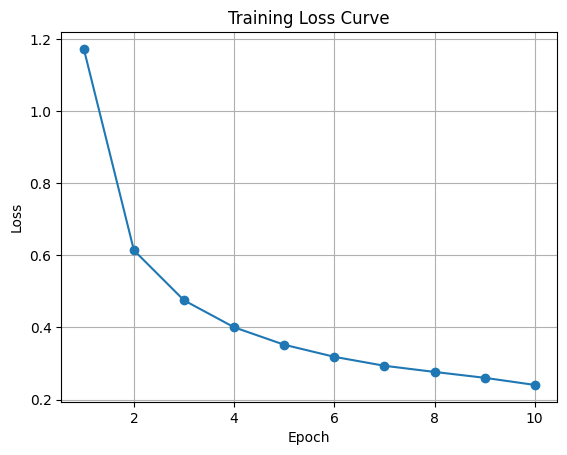

In [7]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assume model and train_loader are defined elsewhere

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    train_accuracy = 100 * correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

# Plot the training loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [8]:
model.eval()
running_loss = 0.0
correct_predictions = 0
total_predictions = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    # logits = outputs.logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Calculate training accuracy
    _, predicted = torch.max(outputs, 1)
    total_predictions += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

test_accuracy = 100 * correct_predictions / total_predictions

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.34%


In [12]:
print(model)

Sequential(
  (0): ConvNeXtStage(
    (downsample): Identity()
    (blocks): Sequential(
      (0): ConvNeXtBlock(
        (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=512, out_features=128, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (shortcut): Identity()
        (drop_path): Identity()
      )
      (1): ConvNeXtBlock(
        (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU()
          (drop

In [1]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [2]:
import sys

sys.path.append('./pytorch-grad-cam')

In [3]:
!pip install -r pytorch-grad-cam/requirements.txt

In [4]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [9]:
loaded_model_h5=model

In [10]:
# Layer name of each layer, used for deciding which layer to freeze
for name, module in loaded_model_h5.named_modules():
    print(name)

# Decide which layer to freeze


stem
stem.0
stem.1
stages
stages.0
stages.0.downsample
stages.0.blocks
stages.0.blocks.0
stages.0.blocks.0.conv_dw
stages.0.blocks.0.norm
stages.0.blocks.0.mlp
stages.0.blocks.0.mlp.fc1
stages.0.blocks.0.mlp.act
stages.0.blocks.0.mlp.drop1
stages.0.blocks.0.mlp.norm
stages.0.blocks.0.mlp.fc2
stages.0.blocks.0.mlp.drop2
stages.0.blocks.0.shortcut
stages.0.blocks.0.drop_path
stages.0.blocks.1
stages.0.blocks.1.conv_dw
stages.0.blocks.1.norm
stages.0.blocks.1.mlp
stages.0.blocks.1.mlp.fc1
stages.0.blocks.1.mlp.act
stages.0.blocks.1.mlp.drop1
stages.0.blocks.1.mlp.norm
stages.0.blocks.1.mlp.fc2
stages.0.blocks.1.mlp.drop2
stages.0.blocks.1.shortcut
stages.0.blocks.1.drop_path
stages.0.blocks.2
stages.0.blocks.2.conv_dw
stages.0.blocks.2.norm
stages.0.blocks.2.mlp
stages.0.blocks.2.mlp.fc1
stages.0.blocks.2.mlp.act
stages.0.blocks.2.mlp.drop1
stages.0.blocks.2.mlp.norm
stages.0.blocks.2.mlp.fc2
stages.0.blocks.2.mlp.drop2
stages.0.blocks.2.shortcut
stages.0.blocks.2.drop_path
stages.1
stag

In [13]:
freeze_layers = ["head.fc"]
# Output Layer name for which training is ON
for name, parameter in loaded_model_h5.named_parameters():
  if any(freeze_layer in name for freeze_layer in freeze_layers):
    parameter.requires_grad = True
    print(name)

head.fc.weight
head.fc.bias


In [14]:
target_layers = [loaded_model_h5.head.fc]

In [15]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.LANCZOS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.

    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]

    imgA = (imgA - 0.485)/(0.229)
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)

    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC

    npImage = np.transpose(npImage, (2,0,1))

    return npImage

In [18]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data/Onion_Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

/tmp/ipykernel_2626848/2091123924.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])


torch.Size([1, 3, 224, 224])


AxisError: axis 2 is out of bounds for array of dimension 2

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Define the image processing function
def process_image(img):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return preprocess(img).unsqueeze(0)

# Load your model (make sure it's on the same device as your input tensor)
# loaded_model_h5 = torch.load('your_model.pth')
# loaded_model_h5.eval()

# Define the target layers
target_layers = [loaded_model_h5.head.fc]  # Modify this to match your model's architecture

# Load and preprocess the image
image_path = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data/Onion_Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG'
image = Image.open(image_path)
input_tensor = process_image(image)

# Initialize GradCAM
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# Generate CAM
with torch.set_grad_enabled(True):
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]

# Convert the image to a numpy array and normalize it
image = np.asarray(image.resize((224, 224))) / 255.0

# Ensure the image has three channels
if len(image.shape) == 2:
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

# Create the visualization
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)

# Plot the images
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(Image.open(image_path))
plt.show()


AxisError: axis 2 is out of bounds for array of dimension 2

In [24]:
class AttentionMap:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output.mean()
        loss.backward()

        activations = self.activations.detach().cpu().numpy()[0]
        gradients = self.gradients.detach().cpu().numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        attention_map = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            attention_map += w * activations[i]

        attention_map = np.maximum(attention_map, 0)
        attention_map = attention_map / np.max(attention_map)  # Normalize to [0, 1]
        return attention_map


In [25]:
# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
img_path = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data/Onion_Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG'
img = Image.open(img_path)
input_tensor = preprocess(img).unsqueeze(0)


In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the ConvNeXt model
from timm import create_model

# # Load the ConvNeXt model
# model = create_model('convnext_base', pretrained=True)
# model.eval()

# Define a class to compute the attention map
class AttentionMap:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.hooks = []
        for name, module in self.model.named_modules():
            if module == self.target_layer:
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))
                break

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output.mean()
        loss.backward()

        activations = self.activations.detach().cpu().numpy()[0]
        gradients = self.gradients.detach().cpu().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        attention_map = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            attention_map += w * activations[i]

        attention_map = np.maximum(attention_map, 0)
        attention_map = attention_map / np.max(attention_map)  # Normalize to [0, 1]
        return attention_map

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
img_path = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data/Onion_Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG'
img = Image.open(img_path)
input_tensor = preprocess(img).unsqueeze(0)

# Identify the target layer for attention map computation
target_layer = None

# Traverse through the model to find the target layer (assuming it's one of the last convolutional layers)
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        target_layer = module
        break

if target_layer is None:
    raise RuntimeError("Target layer not found. Ensure the model structure is compatible.")

# Generate attention map
attention_map_generator = AttentionMap(model, target_layer)
attention_map = attention_map_generator.generate(input_tensor)

# Remove hooks after generating attention map
attention_map_generator.remove_hooks()

# Visualize the attention map
plt.imshow(attention_map, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()


AttributeError: 'NoneType' object has no attribute 'detach'